In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import torch

/Users/edvard/Documents/Imperial College/Year 4/Final Year Project/Final-Year-Project/timegrad/.venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
from gluonts.dataset.multivariate_grouper import MultivariateGrouper
from gluonts.dataset.repository.datasets import dataset_recipes, get_dataset
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import MultivariateEvaluator

In [6]:
from pts.model.tempflow import TempFlowEstimator
from pts.model.time_grad import TimeGradEstimator
from pts.model.transformer_tempflow import TransformerTempFlowEstimator
from pts import Trainer

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
device = torch.device("cpu")

In [8]:
def plot(target, forecast, prediction_length, prediction_intervals=(50.0, 90.0), color='g', fname=None):
    label_prefix = ""
    rows = 4
    cols = 4
    fig, axs = plt.subplots(rows, cols, figsize=(24, 24))
    axx = axs.ravel()
    seq_len, target_dim = target.shape
    
    ps = [50.0] + [
            50.0 + f * c / 2.0 for c in prediction_intervals for f in [-1.0, +1.0]
        ]
        
    percentiles_sorted = sorted(set(ps))
    
    def alpha_for_percentile(p):
        return (p / 100.0) ** 0.3
        
    for dim in range(0, min(rows * cols, target_dim)):
        ax = axx[dim]

        target[-2 * prediction_length :][dim].plot(ax=ax)
        
        ps_data = [forecast.quantile(p / 100.0)[:,dim] for p in percentiles_sorted]
        i_p50 = len(percentiles_sorted) // 2
        
        p50_data = ps_data[i_p50]
        p50_series = pd.Series(data=p50_data, index=forecast.index)
        p50_series.plot(color=color, ls="-", label=f"{label_prefix}median", ax=ax)
        
        for i in range(len(percentiles_sorted) // 2):
            ptile = percentiles_sorted[i]
            alpha = alpha_for_percentile(ptile)
            ax.fill_between(
                forecast.index,
                ps_data[i],
                ps_data[-i - 1],
                facecolor=color,
                alpha=alpha,
                interpolate=True,
            )
            # Hack to create labels for the error intervals.
            # Doesn't actually plot anything, because we only pass a single data point
            pd.Series(data=p50_data[:1], index=forecast.index[:1]).plot(
                color=color,
                alpha=alpha,
                linewidth=10,
                label=f"{label_prefix}{100 - ptile * 2}%",
                ax=ax,
            )

    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]    
    axx[0].legend(legend, loc="upper left")
    
    if fname is not None:
        plt.savefig(fname, bbox_inches='tight', pad_inches=0.05)

In [9]:
print(f"Available datasets: {list(dataset_recipes.keys())}")

Available datasets: ['constant', 'exchange_rate', 'solar-energy', 'electricity', 'traffic', 'exchange_rate_nips', 'electricity_nips', 'traffic_nips', 'solar_nips', 'wiki-rolling_nips', 'taxi_30min', 'kaggle_web_traffic_with_missing', 'kaggle_web_traffic_without_missing', 'kaggle_web_traffic_weekly', 'm1_yearly', 'm1_quarterly', 'm1_monthly', 'nn5_daily_with_missing', 'nn5_daily_without_missing', 'nn5_weekly', 'tourism_monthly', 'tourism_quarterly', 'tourism_yearly', 'cif_2016', 'london_smart_meters_without_missing', 'wind_farms_without_missing', 'car_parts_without_missing', 'dominick', 'fred_md', 'pedestrian_counts', 'hospital', 'covid_deaths', 'kdd_cup_2018_without_missing', 'weather', 'm3_monthly', 'm3_quarterly', 'm3_yearly', 'm3_other', 'm4_hourly', 'm4_daily', 'm4_weekly', 'm4_monthly', 'm4_quarterly', 'm4_yearly', 'm5']


In [10]:
# exchange_rate_nips, electricity_nips, traffic_nips, solar_nips, wiki-rolling_nips, ## taxi_30min is buggy still
dataset = get_dataset("electricity_nips", regenerate=False)

In [11]:
dataset.metadata

MetaData(freq='H', target=None, feat_static_cat=[CategoricalFeatureInfo(name='feat_static_cat_0', cardinality='370')], feat_static_real=[], feat_dynamic_real=[], feat_dynamic_cat=[], prediction_length=24)

In [15]:
dataset.train.__dict__

{'cache': False,
 'path': PosixPath('/Users/edvard/.mxnet/gluon-ts/datasets/electricity_nips/train'),
 'process': <gluonts.dataset.common.ProcessDataEntry at 0x146203d30>,
 '_len_per_file': None,
 '_json_line_files': [<gluonts.dataset.jsonl.JsonLinesFile at 0x1462f8c40>]}

In [10]:
train_grouper = MultivariateGrouper(max_target_dim=min(2000, int(dataset.metadata.feat_static_cat[0].cardinality)))

test_grouper = MultivariateGrouper(num_test_dates=int(len(dataset.test)/len(dataset.train)), 
                                   max_target_dim=min(2000, int(dataset.metadata.feat_static_cat[0].cardinality)))

In [11]:
dataset_train = train_grouper(dataset.train)
dataset_test = test_grouper(dataset.test)

/Users/edvard/Documents/Imperial College/Year 4/Final Year Project/Final-Year-Project/timegrad/.venv/lib/python3.8/site-packages/gluonts/dataset/multivariate_grouper.py:184: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return {FieldName.TARGET: np.array([funcs(data) for data in dataset])}


In [12]:
estimator = TimeGradEstimator(
    target_dim=int(dataset.metadata.feat_static_cat[0].cardinality),
    prediction_length=dataset.metadata.prediction_length,
    context_length=dataset.metadata.prediction_length,
    cell_type='GRU',
    input_size=1484,
    freq=dataset.metadata.freq,
    loss_type='l2',
    scaling=True,
    diff_steps=100,
    beta_end=0.1,
    beta_schedule="linear",
    trainer=Trainer(device=device,
                    epochs=1,
                    learning_rate=1e-3,
                    num_batches_per_epoch=100,
                    batch_size=64,)
)

In [13]:
predictor = estimator.train(dataset_train, num_workers=8)

  0%|          | 0/99 [00:00<?, ?it/s]/Users/edvard/Documents/Imperial College/Year 4/Final Year Project/Final-Year-Project/timegrad/.venv/lib/python3.8/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/Users/edvard/Documents/Imperial College/Year 4/Final Year Project/Final-Year-Project/timegrad/.venv/lib/python3.8/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/Users/edvard/Documents/Imperial College/Year 4/Final Year Project/Final-Year-Project/timegrad/.venv/lib/python3.8/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/Users/edvard/Documents/Imperial College/Y

In [14]:
forecast_it, ts_it = make_evaluation_predictions(dataset=dataset_test,
                                                 predictor=predictor,
                                                 num_samples=100)

In [15]:
forecasts = list(forecast_it)
targets = list(ts_it)

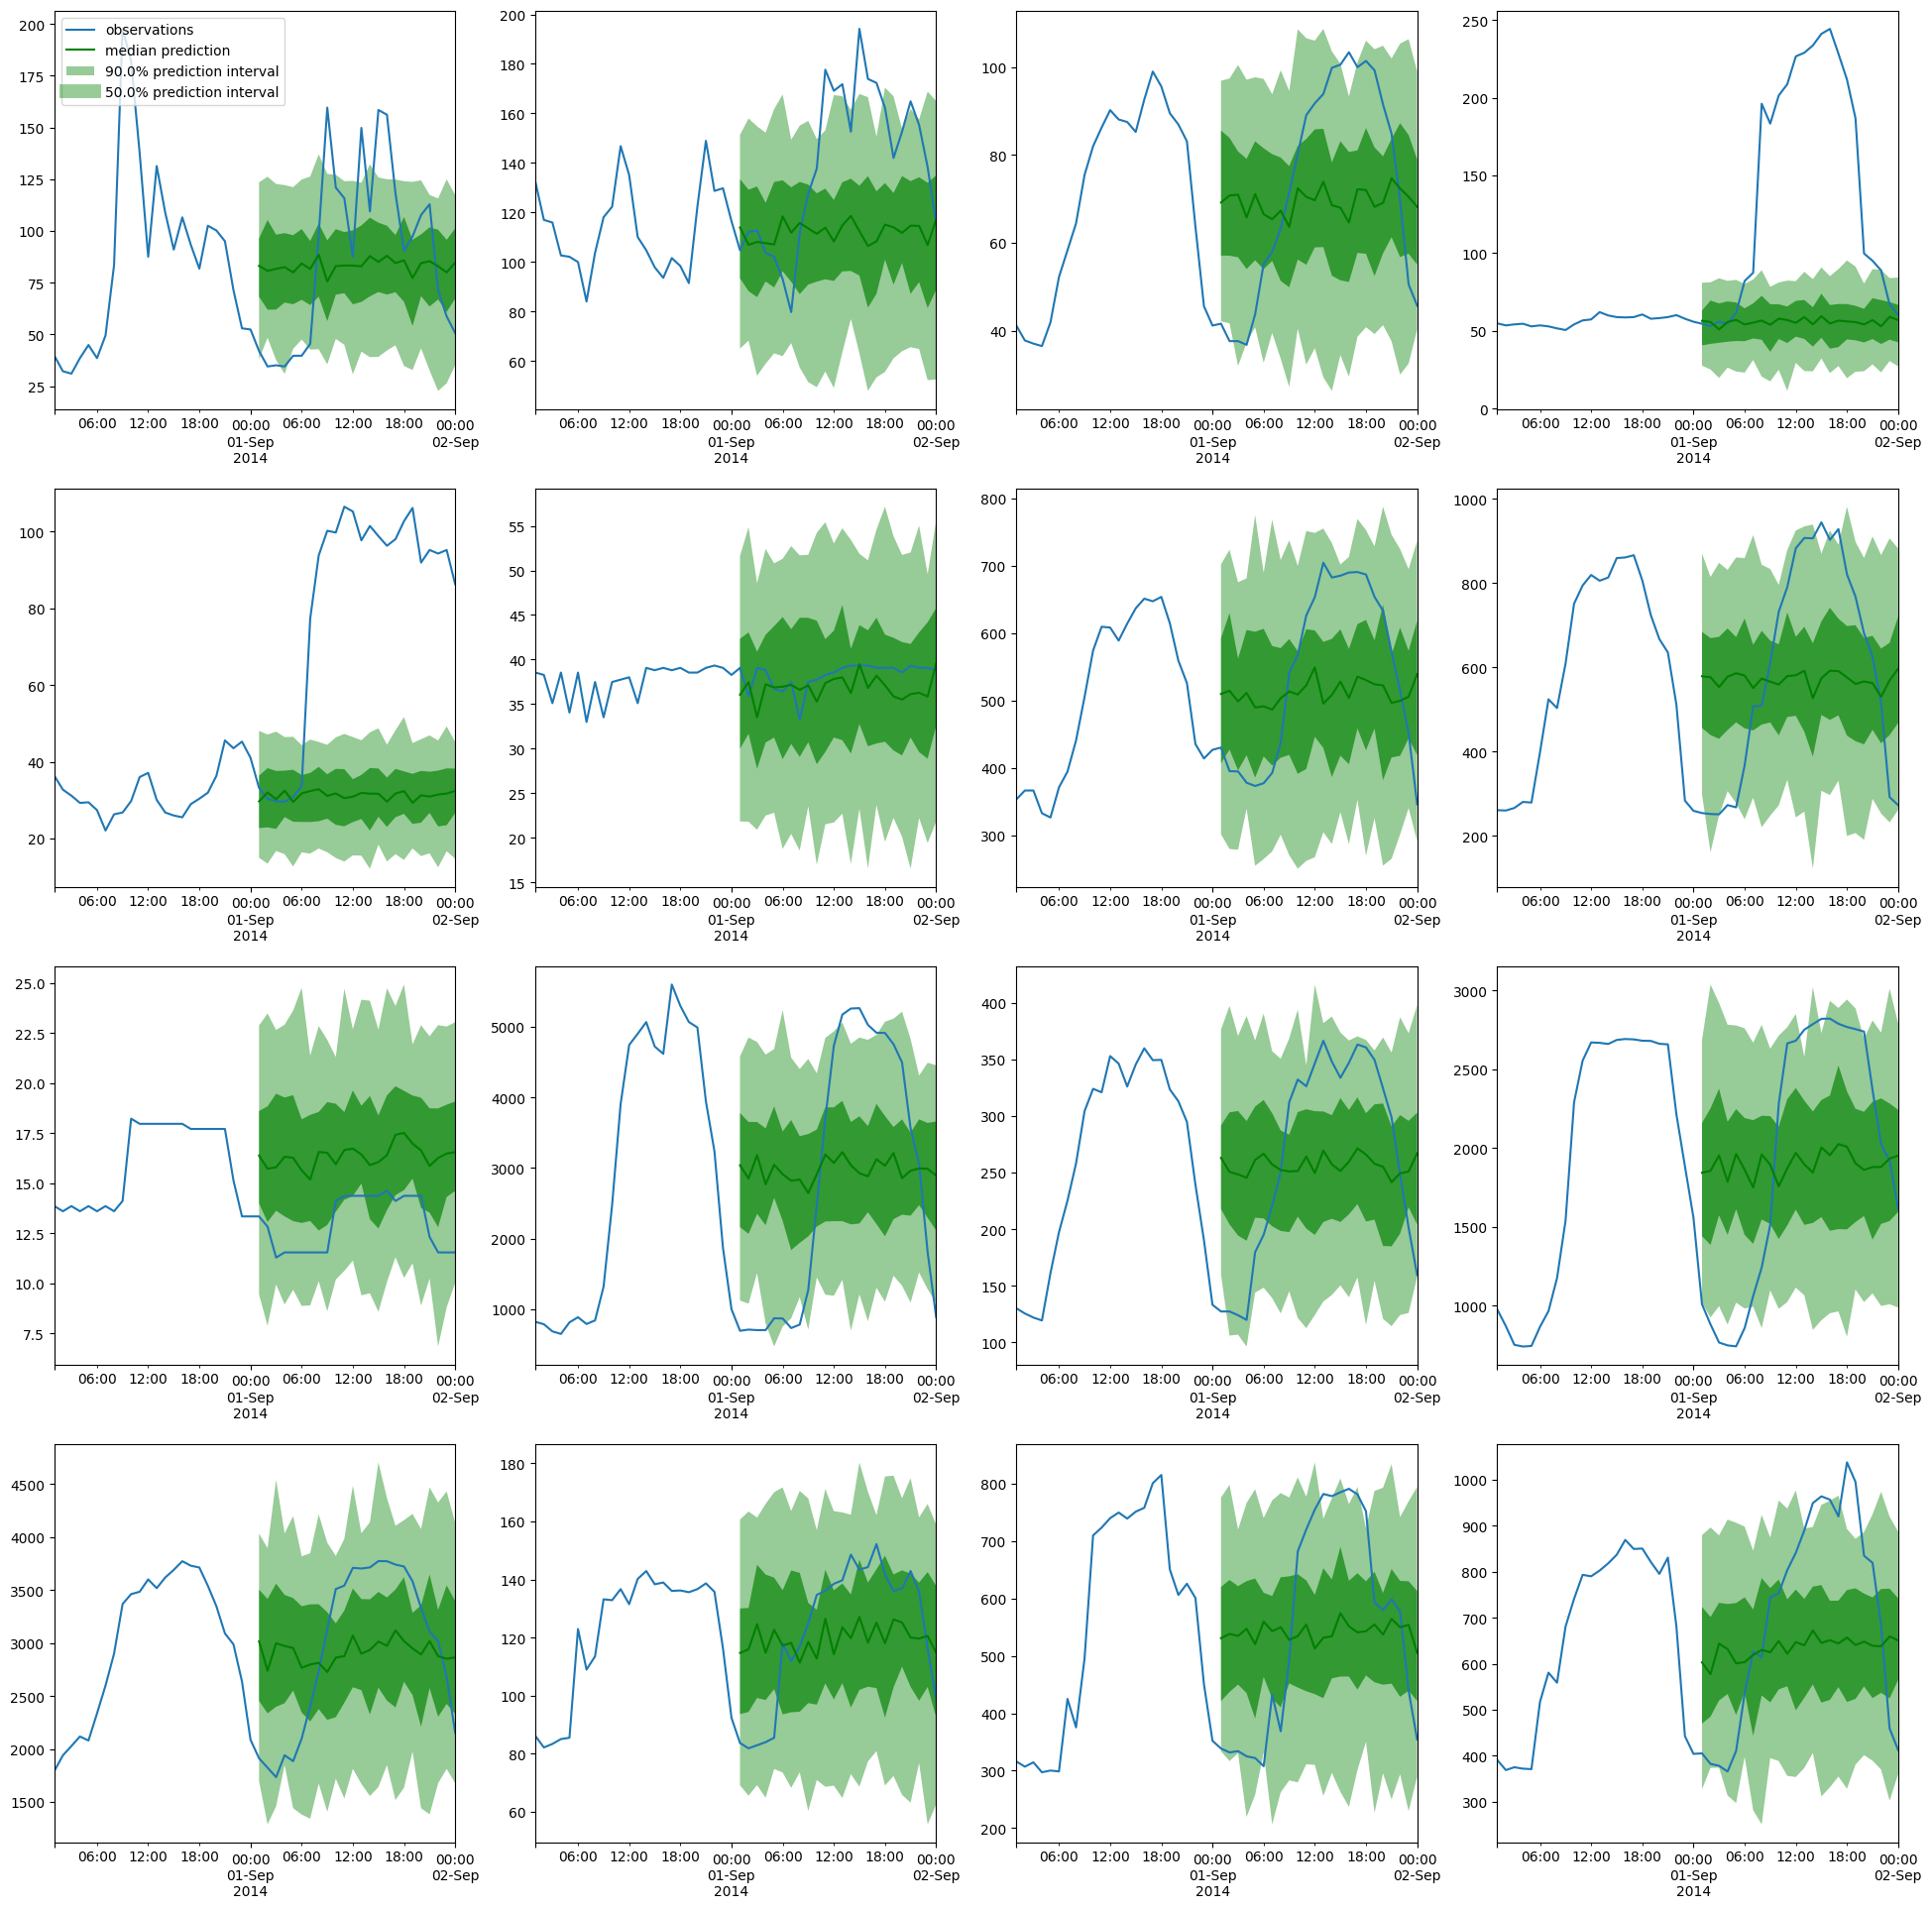

In [ ]:
plot(
    target=targets[0],
    forecast=forecasts[0],
    prediction_length=dataset.metadata.prediction_length,
)
plt.show()

In [ ]:
evaluator = MultivariateEvaluator(quantiles=(np.arange(20)/20.0)[1:], 
                                  target_agg_funcs={'sum': np.sum})

In [ ]:
agg_metric, item_metrics = evaluator(targets, forecasts, num_series=len(dataset_test))

Running evaluation: 7it [00:00, 255.60it/s]
Running evaluation: 7it [00:00, 257.26it/s]
Running evaluation: 7it [00:00, 256.26it/s]
Running evaluation: 7it [00:00, 261.73it/s]
Running evaluation: 7it [00:00, 246.20it/s]
Running evaluation: 7it [00:00, 268.62it/s]
Running evaluation: 7it [00:00, 263.29it/s]
Running evaluation: 7it [00:00, 269.68it/s]
Running evaluation: 7it [00:00, 267.87it/s]
Running evaluation: 7it [00:00, 266.16it/s]
Running evaluation: 7it [00:00, 263.84it/s]
Running evaluation: 7it [00:00, 257.01it/s]
Running evaluation: 7it [00:00, 231.45it/s]
Running evaluation: 7it [00:00, 249.85it/s]
Running evaluation: 7it [00:00, 232.56it/s]
Running evaluation: 7it [00:00, 234.10it/s]
Running evaluation: 7it [00:00, 241.78it/s]
Running evaluation: 7it [00:00, 235.80it/s]
Running evaluation: 7it [00:00, 237.85it/s]
Running evaluation: 7it [00:00, 248.42it/s]
Running evaluation: 7it [00:00, 238.83it/s]
Running evaluation: 7it [00:00, 234.80it/s]
Running evaluation: 7it [00:00, 

In [ ]:
print("CRPS:", agg_metric["mean_wQuantileLoss"])
print("ND:", agg_metric["ND"])
print("NRMSE:", agg_metric["NRMSE"])
print("")
print("CRPS-Sum:", agg_metric["m_sum_mean_wQuantileLoss"])
print("ND-Sum:", agg_metric["m_sum_ND"])
print("NRMSE-Sum:", agg_metric["m_sum_NRMSE"])

CRPS: 0.26689025637072333
ND: 0.3614609545418663
NRMSE: 3.4329515886203286

CRPS-Sum: 0.28231804248625264
ND-Sum: 0.33401530714973354
NRMSE-Sum: 0.3553718669177864


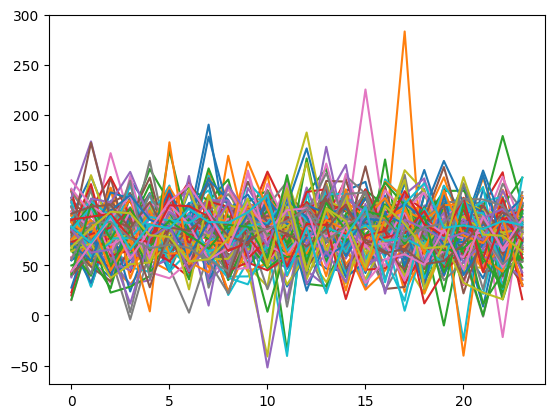

In [ ]:
# Extract forecasts for 0th day and 0th time series
for individual_forecast in forecasts[0].samples[:,:,0]: # Day 0 for person 0
    plt.plot(individual_forecast)

In [ ]:
# Get a single prediction

from gluonts.dataset.common import ListDataset

test_ds = ListDataset(
    [
        {
            "target": np.zeros((370,4000)),
            "start": pd.Timestamp(2023,1,2),
            'feat_static_cat': [0],
        }
    ],
    freq="H",
)

In [ ]:
a, b = make_evaluation_predictions(
    dataset=test_ds,
    predictor=predictor,
    num_samples=100
)

In [ ]:
a, b = make_evaluation_predictions(
    dataset=dataset_test,
    predictor=predictor,
    num_samples=100
)

In [ ]:
list(a)

In [ ]:
dataset_test.__dict__.keys()

dict_keys(['process', 'list_data'])

In [ ]:
test_ds.__dict__.keys()

dict_keys(['process', 'list_data'])

In [ ]:
pd.Timestamp(2023,1,1)

Timestamp('2023-01-01 00:00:00')

In [ ]:
dataset_test.list_data["target"]

[{'target': array([[141.70506 , 141.12903 , 119.81567 , ...,  71.42857 ,  58.75576 ,
           50.691246],
         [153.19148 , 183.51064 , 153.7234  , ..., 155.31915 , 138.29787 ,
          115.42553 ],
         [ 67.242355,  67.80861 ,  77.57645 , ...,  69.648926,  50.537937,
           45.7248  ],
         ...,
         [157.96083 , 174.87328 , 192.54993 , ..., 147.2043  , 111.4593  ,
          121.831795],
         [255.66438 , 269.4007  , 293.10275 , ..., 249.82535 , 149.88014 ,
          145.42465 ],
         [ 90.4176  ,  91.34974 ,  89.858315, ...,  97.50186 ,  70.84265 ,
           66.18195 ]], dtype=float32),
  'start': Timestamp('2014-03-19 09:00:00', freq='H'),
  'feat_static_cat': [0]},
 {'target': array([[  0.      ,   0.      ,   0.      , ...,  65.09216 ,  58.75576 ,
           48.387096],
         [  0.      ,   0.      ,   0.      , ..., 144.68085 , 140.95744 ,
          125.53191 ],
         [  0.      ,   0.      ,   0.      , ...,  71.77237 ,  56.342014,
        

In [ ]:
np.zeros((370,4000)).shape

(370, 4000)

In [ ]:
k = np.array([[i for i in range(24)] for _ in range(370)])
print(k.shape)

(370, 24)


In [ ]:
dataset_test.list_data[0]["target"].shape

(370, 4000)

In [ ]:
a = predictor.predict(dataset=test_ds,num_samples=10)

In [ ]:
m = list(a)

GluonTSDataError: Array 'target' has bad shape - expected 1 dimensions, got 2.